<a href="https://colab.research.google.com/github/RFajardoMonzon/MachineLearningCourse/blob/master/Keras_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 12 - Autoencoders.

*   Recuerda que puedes consultar la documentación sobre una función escribiendo **?** justo después de la función: *Ejemplo: np.maximum?*
*   Puedes ejecutar el contenido de una celda con el atajo de teclado **CTRL+ENTER**
*   Utiliza **TAB** cada vez que quieras autocompletar una llamada a una función.
*   Puedes ejecutar instrucciones de bash directamente desde el notebook usando **!** : *Ejemplo: !pip install tensorflow*
*   Recuerda que Google es tu amigo, y saber buscar la información en las documentaciones de las librerías es muy importante.
*   Una solución correcta no es la que funciona sino la que se entiende!
*   No dudes en preguntar cualquier duda al profesor que lleva todo el día dando la turra.

## 1. Autoencoders y espacios latentes con MNIST.

No... si ya me sabe mal volver al maldito dataset MNIST, pero es que... ya conociéndolo, podemos aprovechar mucho del código que hemos desarrollado en ejercicios anteriores para trabajar más rápido. En cualquier caso, si lo prefieres, puedes trabajar con otros datasets similares. Por ejemplo, puedes probar a trabajar con el Fashion MNIST (de complementos de moda) o notMNIST (de diferentes tipografías).

Hoy lo que vamos a hacer es implementar nuestro propio ***AUTOENCODER***, y con él, extraer vectores de nuestro espacio latente. Al turrón!

---

**Tarea:** Lo primero en lo que tienes que trabajar es en ENTENDER cómo se puede diseñar un modelo como el ***Autoencoder*** en Keras. Para ello te facilito abajo el código ya implementado. Estúdialo y leéte los comentario de cada linea para llegar a entender a la perfección lo que está sucediendo. Completa los comentarios escribiendo en cada linea la dimensión asociada en cada capa. Recuerda que en este caso construiremos como partes independientes los modelos del ***encoder*** y el ***decoder***, y luego los uniremos para conformar el modelo final: El Autoencoder.

**Pregunta** : ¿Qué función de activación crees que es mejor elegir para utilizar en la última capa del ***decoder***: ¿*ReLU*, *Sigmoide* o *Softmax*?¿Por qué? Pista : La solución rima con *palanganoide*. 

Una vez tengas tu *autoencoder* construido y funcionando realiza lo siguiente:

1. Haz que tu autoencoder sólo tenga dos neuronas en su cuello de botella y entrena al modelo. Una vez lo tengas, prueba a visualizar una imagen de entrada y el output reconstruido por la red. ¿Es una buena reconstrucción? Si no estás convencido del resultado, comprueba que el autoencoder ha hecho su trabajo, visualizando un ***scatter plot*** donde cada variable latente estará en un eje, y donde cada clase se visualice de un color. Si tu modelo es correcto, deberías de observar cómo números de clases similares estarán en posiciones cercanas formando clusters.


In [0]:
import numpy as np
import scipy as sc
import sklearn as sk
import pandas  as pd
import seaborn as sb
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.models     import Sequential, Model
from tensorflow.keras.layers     import Dense, Input, Conv2D, MaxPool2D, Flatten, Conv2DTranspose, UpSampling2D, MaxPooling2D, Reshape
from tensorflow.keras.utils      import to_categorical
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split

# Cargamos el dataset desde el archivo.
mnist = pd.read_csv("./sample_data/mnist_train_small.csv", header=None).values

# Guardamos las variables X e Y.
X, Y = mnist[:, 1:], mnist[:, 0:1]

n, p = X.shape

size = int(np.sqrt(p))

# Normalizamos input y codificamos output con one-hot encoding.
Xt = X / 255.0
Yt = to_categorical(Y, 10)

# Generamos train y test set.
X_train, X_test, Y_train, Y_test = train_test_split(Xt, Yt, train_size=0.7)

In [0]:
z = 2 # Tamaño del vector intermedio del autoencoder.

# Primero creamos el input para el encoder.
inpE = Input(shape=(size, size, 1))     # BSx28x28x1

# Y cambiamos el input a un vector unidimensional.
x = Flatten()(inpE)                     # BSx784
x = Dense(256, activation='relu')(x)    # 256
x = Dense(128, activation='relu')(x)    # 128
x = Dense(64,  activation='relu')(x)    # 64

# La última capa del encoder nos da el vector latente.
c = Dense(z)(x)                         # z 

# Ahora definimos el input del decoder.
inpD = Input(shape=c.shape[1:])         # z

# Y empezamos a revertir los pasos del encoder.
x = Dense(64,  activation='relu')(inpD) # 64
x = Dense(128, activation='relu')(x)    # 128
x = Dense(256, activation='relu')(x)    # 256
x = Dense(784, activation='sigmoid')(x) # BSx784

# Finalmente recuperamos la forma original de la imagen.
x = Reshape(inpE.shape[1:])(x)          # BSx28x28x1

" -------- "


# Ahora, para tener el control total de todas las partes del modelo, vamos
# a definir cada parte por separado. 

# El encoder será un modelo cuyo input es
# el input del encoder y el output el código.

# El decoder será un modelo cuyo input es el input
# del decoder y el output la imagen recuperada.
encoder = Model(inputs=inpE, outputs=c)
decoder = Model(inputs=inpD, outputs=x)


# Nos faltaría conectar el encoder con el decoder para formar el autoencoder. 

# (wow. vaya frase!)

# Para eso definimos un nuevo Input, el que será el Input 
# de nuestro modelo completo...
inpA = Input(shape=(size, size, 1))

# ...y creamos dicho modelo definiendo como input el que acabamos de crear,
# y ojo a cómo conseguimos conectar ambas partes. 

# Contémplalo. Analízalo. Disfrútalo. 
autoencoder = Model(inputs=inpA, outputs=decoder(encoder(inpA)))


# A partir de aquí simplemente compilamos y optimizamos como hacíamos anteriormente.
autoencoder.compile(optimizer=SGD(5), loss='mse')

autoencoder.fit(X_train.reshape(-1, size, size, 1), 
                X_train.reshape(-1, size, size, 1),
                validation_data=(X_test.reshape(-1, size, size, 1), X_test.reshape(-1, size, size, 1)),
                epochs=100,
                batch_size=128)


# Cuando hayas terminado de entenderlo, puedes retirar todo el código y
# contemplar las pocas lineas que necesitamos para construir nuestro rico
# autoencoder.


Train on 14000 samples, validate on 6000 samples
Epoch 1/100
14000/14000 [==============================] - 1s 72us/sample - loss: 0.1078 - val_loss: 0.0683
Epoch 2/100
14000/14000 [==============================] - 1s 38us/sample - loss: 0.0658 - val_loss: 0.0657
Epoch 3/100
14000/14000 [==============================] - 1s 39us/sample - loss: 0.0648 - val_loss: 0.0685
Epoch 4/100
14000/14000 [==============================] - 1s 38us/sample - loss: 0.0638 - val_loss: 0.0639
Epoch 5/100
14000/14000 [==============================] - 1s 39us/sample - loss: 0.0609 - val_loss: 0.0603
Epoch 6/100
14000/14000 [==============================] - 1s 39us/sample - loss: 0.0589 - val_loss: 0.0588
Epoch 7/100
14000/14000 [==============================] - 1s 38us/sample - loss: 0.0573 - val_loss: 0.0575
Epoch 8/100
14000/14000 [==============================] - 1s 38us/sample - loss: 0.0563 - val_loss: 0.0567
Epoch 9/100
14000/14000 [==============================] - 1s 39us/sample - loss: 0.055

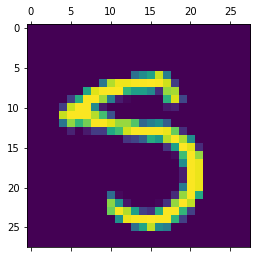

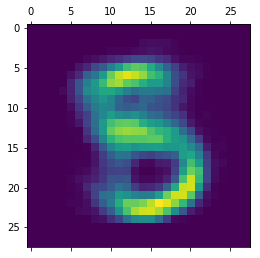

In [0]:
random_index = np.random.randint(X_test.shape[0])
random_image = X_test[random_index].reshape(size, size)
predicted_image = autoencoder.predict(random_image.reshape(1, size, size, 1))
plt.matshow(random_image)
# plt.title("El número es: {}".format(Y[random_index, 0]))
plt.show()
plt.matshow(predicted_image.reshape(size, size))
plt.show()

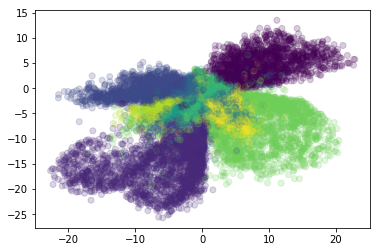

In [0]:
encoded_images = encoder.predict(Xt.reshape(-1, size, size, 1))
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=Y.ravel(), alpha=0.2)
plt.show()

## 2. Autoencoder Convolucional.

---

**Tarea:** Utiliza como referencia la manera en la que hemos implementado el ***Autoencoder*** del ejercicio anterior, para diseñar ahora un ***Autoencoder Convolucional*** que siga el diseño de la imagen inferior. Para ello deberás de definir correctamente los parámetros de la capa *Conv2D()* - por ejemplo el parámetro *filters*, *kernel_size* y el *strides* - y comprobar que las dimensiones se ajustan a lo esperado. En este caso, esta arquitectura no hace uso de las capas de ***MaxPooling()***. Como ya hemos mencionado con anterioridad, la mayor dificultad a la hora de diseñar estas arquitecturas. Las p*** dimensiones.

> > > > <img src="https://www.researchgate.net/profile/Xifeng_Guo/publication/320658590/figure/fig1/AS:614154637418504@15234372844108/The-structure-of-proposed-Convolutional-AutoEncoders-CAE-for-MNIST-In-the-middle-there.png" alt="Drawing" width="600px"/>

**(Bonus)** Cuando hayas diseñado y entrenado a tu ***Autoencoder Convolucional*** correctamente, puedes experimentar con las siguientes propiedades del modelo:
 

> **1.** *Autoencoder Denoiser :* Genera una imagen con ruido y comprueba que tu modelo es capaz de eliminarlo. Prueba diferentes con diferentes niveles de ruidos hasta que la reconstrucción no sea posible. En ese punto, prueba a añadir ruido al *input* (utiliza la función implementada hace un par de ejercicios) y entrena a tu ***autoencoder*** para comprobar si tu modelo es capaz de actuar como un *denoiser*.

> **2.** *Interpolaciones :* Genera vectores latentes para dos tipos de imágenes y visualízalas. Después haz la interpolación matemática entre los dos vectores, para diferentes grados de mezcla, y con los vectores resultantes, reconstruye las imágenes con el* Decoder()*. ¿Se produce algún tipo de interpolación? 


In [0]:
from tensorflow.keras.backend import clear_session

clear_session()

z = 10

inpE = Input(shape=(size, size, 1))     
                   
x = Conv2D(32, (2, 2), strides=2, activation='relu')(inpE)   
print(x.shape)
x = Conv2D(64, (2, 2), strides=2, activation='relu')(x)      
print(x.shape)
x = Conv2D(128, (2, 2), strides=2, activation='relu')(x) 
print(x.shape)
x = Flatten()(x)
print(x.shape)
x = Dense(1152, activation="relu")(x)

c = Dense(z)(x)                        

inpD = Input(shape=c.shape[1:])

x = Dense(1152, activation="relu")(inpD)
x = Reshape((3, 3, 128))(x) 
x = Conv2DTranspose(64, (3, 3), strides=2, activation='relu')(x) 
print(x.shape)
x = Conv2DTranspose(32, (2, 2), strides=2, activation='relu')(x)  
print(x.shape)
x = Conv2DTranspose(1, (2, 2), strides=2, activation='relu')(x) 
print(x.shape)

encoderConv = Model(inputs=inpE, outputs=c)
decoderConv = Model(inputs=inpD, outputs=x)

inpA = Input(shape=(size, size, 1))

autoencoderConv = Model(inputs=inpA, outputs=decoderConv(encoderConv(inpA)))

autoencoderConv.compile(optimizer=SGD(0.5), loss='mse')

autoencoderConv.fit(X_train.reshape(-1, size, size, 1), 
                X_train.reshape(-1, size, size, 1),
                validation_data=(X_test.reshape(-1, size, size, 1), X_test.reshape(-1, size, size, 1)),
                epochs=100,
                batch_size=128)
autoencoderConv.save("conv.h5")


Instructions for updating:
Colocations handled automatically by placer.
(?, 14, 14, 32)
(?, 7, 7, 64)
(?, 3, 3, 128)
(?, 1152)
(?, 7, 7, 64)
(?, 14, 14, 32)
(?, 28, 28, 1)
Instructions for updating:
Use tf.cast instead.
Train on 14000 samples, validate on 6000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
14000/14000 [==============================] - 6s 434us/sample - loss: 0.0952 - val_loss: 0.0950
Epoch 2/100
14000/14000 [==============================] - 1s 51us/sample - loss: 0.0949 - val_loss: 0.0949
Epoch 3/100
14000/14000 [==============================] - 1s 48us/sample - loss: 0.0948 - val_loss: 0.0947
Epoch 4/100
14000/14000 [==============================] - 1s 48us/sample - loss: 0.0945 - val_loss: 0.0943
Epoch 5/100
14000/14000 [==============================] - 1s 48us/sample - loss: 0.0940 - val_loss: 0.0936
Epoch 6/100
14000/14000 [==============================] - 1s 48us/sample - loss: 0.0925 - val_loss: 0.0909
Epoch 7/100
14000/14000 [=========

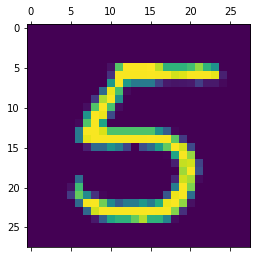

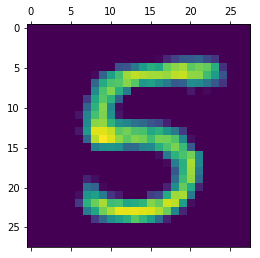

In [0]:
random_index = np.random.randint(X_test.shape[0])
random_image = X_test[random_index].reshape(size, size)
predicted_image = autoencoderConv.predict(random_image.reshape(1, size, size, 1))
plt.matshow(random_image)
plt.show()
plt.matshow(predicted_image.reshape(size, size))
plt.show()

In [0]:
def noise_imgs(X, noise_level=0.5):
  
  # Matriz resultado.
  nois_X = np.zeros(X.shape)
    
  # Convertimos a matriz el vector de píxeles.
  rx = X.reshape(28, 28)
  # Seleccionamos el ángulo con el que rotar la imagen.
  noise = (np.random.random(X.shape) * 2.0  - 1) * noise_level
  # Guardamos la traslación de la imagen.
  return np.clip(X + noise, 0.0, 1.0).flatten()

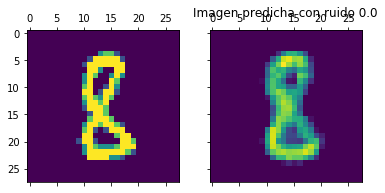

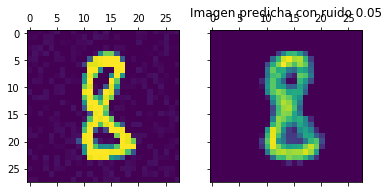

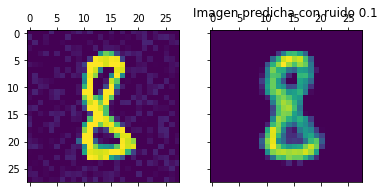

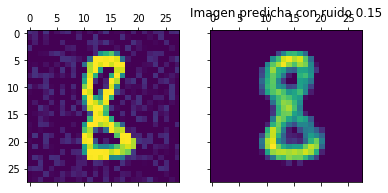

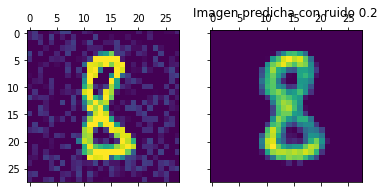

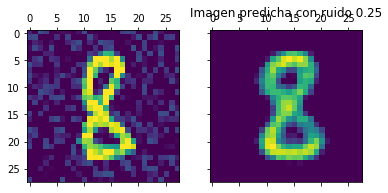

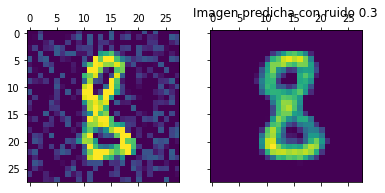

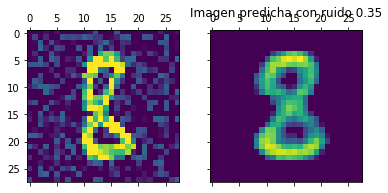

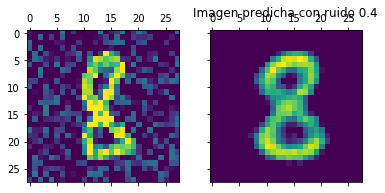

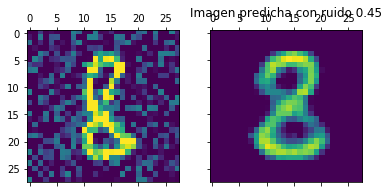

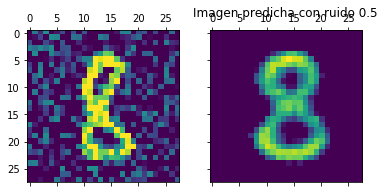

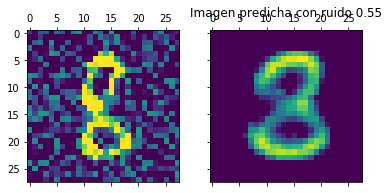

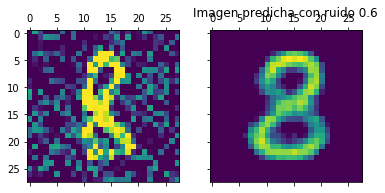

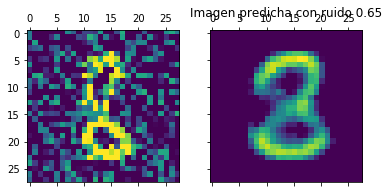

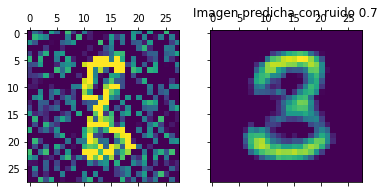

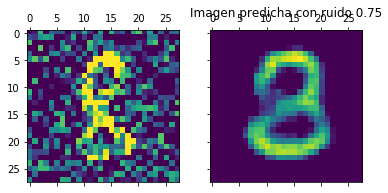

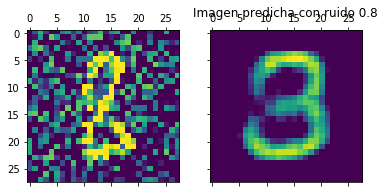

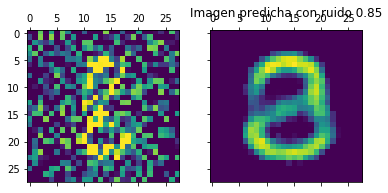

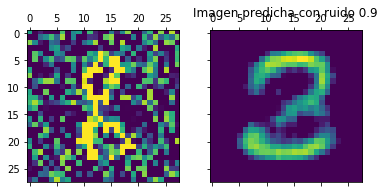

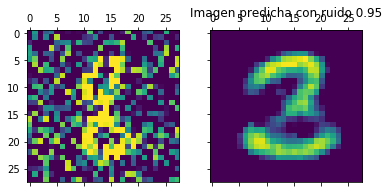

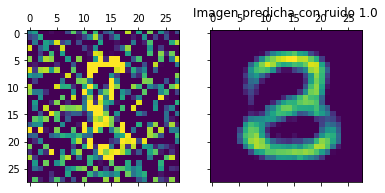

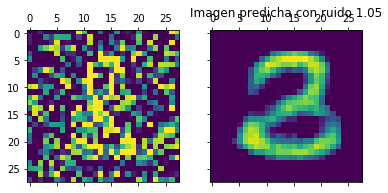

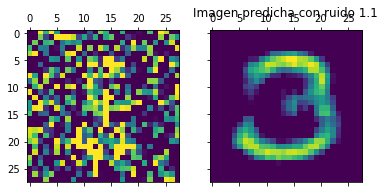

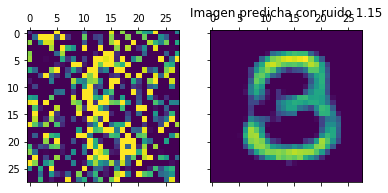

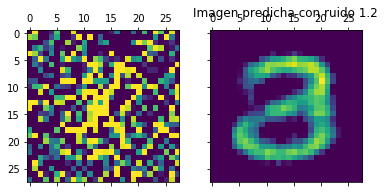

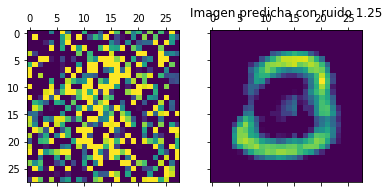

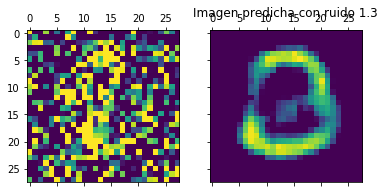

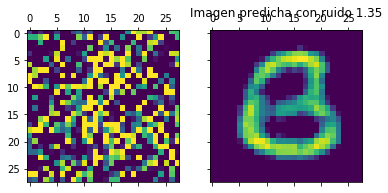

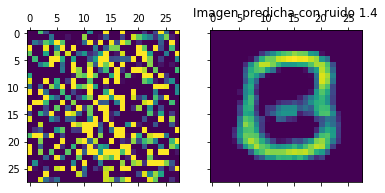

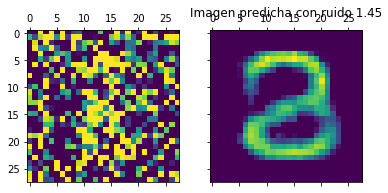

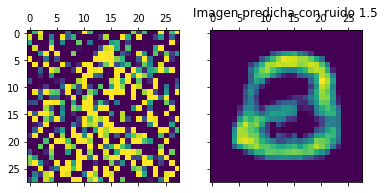

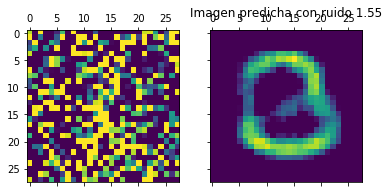

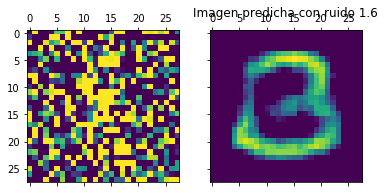

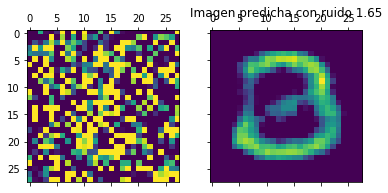

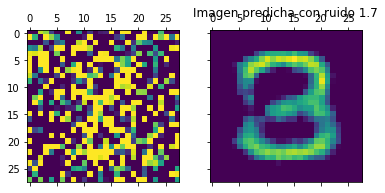

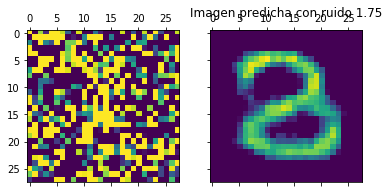

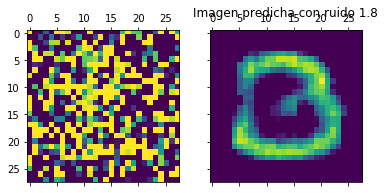

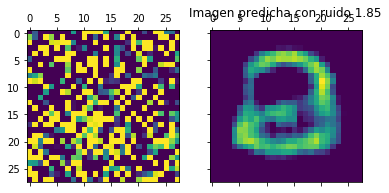

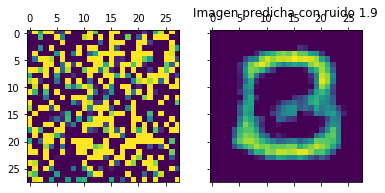

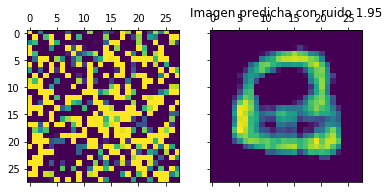

In [0]:
random_image = X_test[np.random.randint(X_test.shape[0])].reshape(size, size)

for noise_level in np.arange(0, 2, 0.05):
  noisy_image = noise_imgs(random_image.reshape(size*size), noise_level).reshape(size, size)
  predicted_image = autoencoderConv.predict(noisy_image.reshape(1, size, size, 1)).reshape(size, size)
  f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
  ax1.matshow(noisy_image)
  ax2.matshow(predicted_image)
  plt.title("Imagen predicha con ruido {}".format(round(noise_level, 2)))
  plt.show()

In [0]:
def getInterp(x1, x2, n):
  x = x2 - x1
  interp = []
  for i in np.arange(n):
    interp.append(x1 + (x/n)*i)
  interp.append(x2)
  return np.array(interp)  

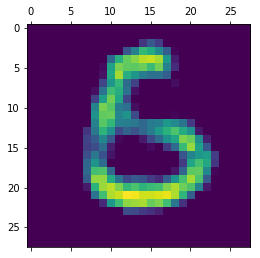

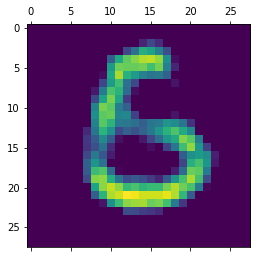

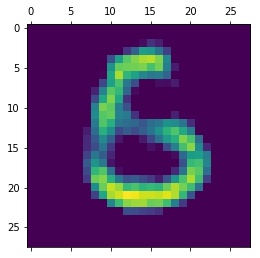

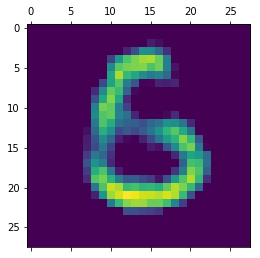

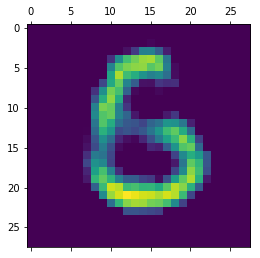

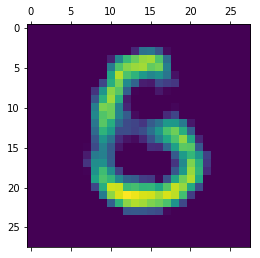

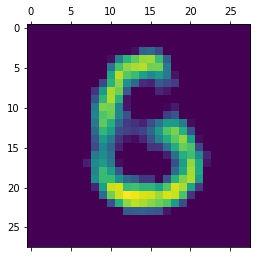

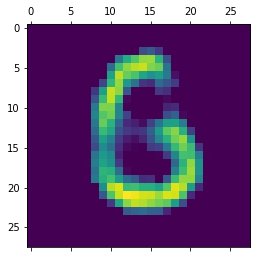

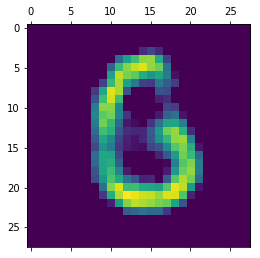

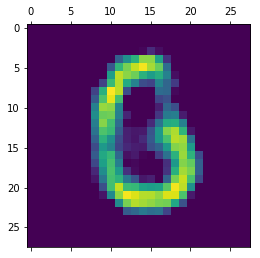

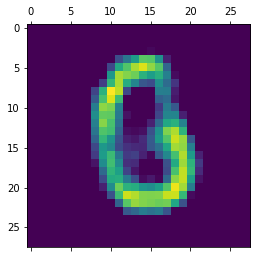

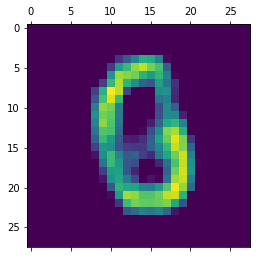

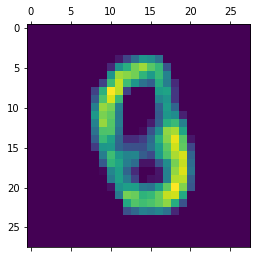

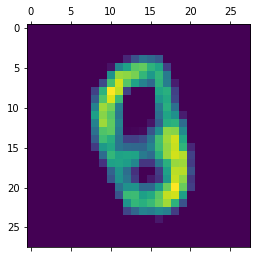

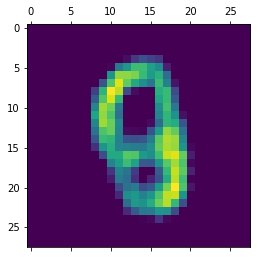

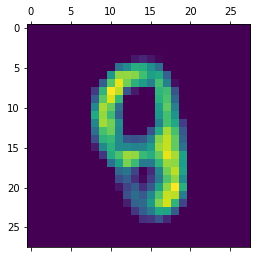

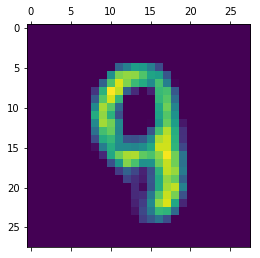

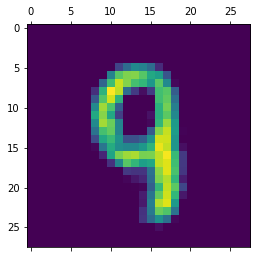

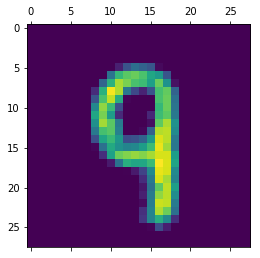

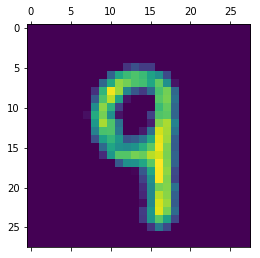

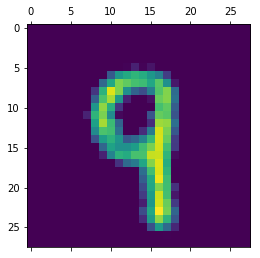

In [0]:
random_image1 = X_test[np.random.randint(X_test.shape[0])].reshape(1, size, size, 1)
random_image2 = X_test[np.random.randint(X_test.shape[0])].reshape(1, size, size, 1)
encoded1 = encoderConv.predict(random_image1)
encoded2 = encoderConv.predict(random_image2)

for encoded in getInterp(encoded1, encoded2, 20):
  plt.matshow(decoderConv.predict(encoded).reshape(28, 28))
  plt.show()

In [0]:
encoderConv.summary()
decoderConv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          8256      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         32896     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 1152)              1328256   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                11530     
Total para